# Facial Detection via Webcam

This project aims at creating a small IA able to detect portrait characteristics : mouth, nose and the face position.

As a beginning, we will take a look inside the database.

This project is made possible by using a preprossed version of the database **YouTube Faces DB**

 Lior Wolf, Tal Hassner and Itay Maoz
*Face Recognition in Unconstrained Videos with Matched Background Similarity.*
IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), 2011.

#### Training and Testing Data

This dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

* 3462 of these images are training images.
* 2308 are test images.


In [4]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

Let's see in what the data base consits by choosing a random image in it.

In [48]:
key_images = pd.read_csv('../data/training_frames_keypoints.csv')

image_name = key_images.iloc[34,0]
key_pts = key_images.iloc[34,1:].values
key_pts = key_pts.astype('float').reshape(-1,2)

print('Name: ', image_name)
print('Shape: ', key_pts.shape)
print('Key pts: {}'.format(key_pts[-4:]))

Name:  Chuck_Woolery_10.jpg
Shape:  (68, 2)
Key pts: [[54. 69.]
 [49. 70.]
 [46. 70.]
 [45. 72.]]


We now print an image with its corresponding key points. To make easier a small function is defined.

In [49]:
def plot_keypoints(image,key_pts):
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='o', c='m')

Chuck_Woolery_10.jpg


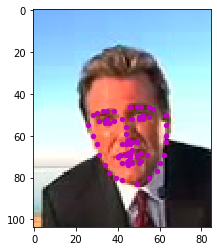

In [50]:
print(image_name)
plot_keypoints(mpimg.imread(os.path.join('../data/training/', image_name)),key_pts)

We need to prepare the data for the training. A dataloader is defined in the *data_gestion.py* file. 
In this file transformation are also defined to improve the data before training.

In [8]:
from data_gestion import ImageDataset, ToTensor, Normalize, RandomCrop, Rescale

We can now define the dataset.

In [9]:
images_dataset = ImageDataset(file='../data/training_frames_keypoints.csv',dir_='../data/training/')

print('Size: ', len(images_dataset))

Size:  3462


And here is what happens if we apply some transformation on a random image in the dataset. 

Agnes_Bruckner_41.jpg


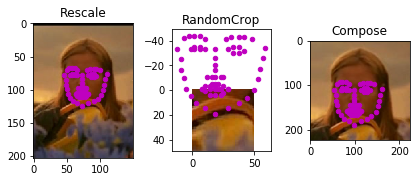

In [13]:
import torch
from torchvision import transforms, utils

rescale = Rescale(150)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])
print(key_images.iloc[42,0])
example = images_dataset[42]

fig = plt.figure()
for i, j in enumerate([rescale, crop, composed]):
    transformed_sample = j(example)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(j).__name__)
    plot_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

Let's now transform the whole database.

In [14]:
transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

transformed_dataset = ImageDataset(file='../data/training_frames_keypoints.csv',dir_='../data/training/',transform=transform)


To make the detection possible we'll proceed in two phases.

*  Using Haar Cascade Detector we will be able to detect faces in an image.
*  Mouth, nose and face countour will be found applying a Convolutional Neural Network. 

# Faces Detection in an image.

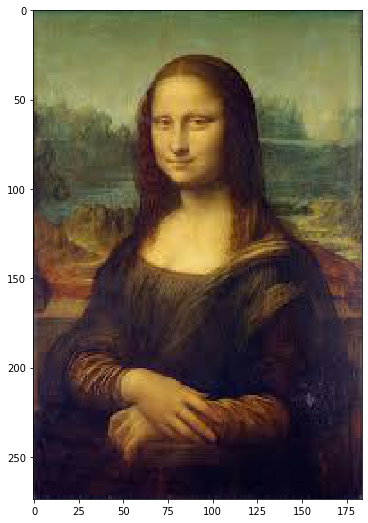

In [15]:
image = cv2.imread('../images/mona_lisa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

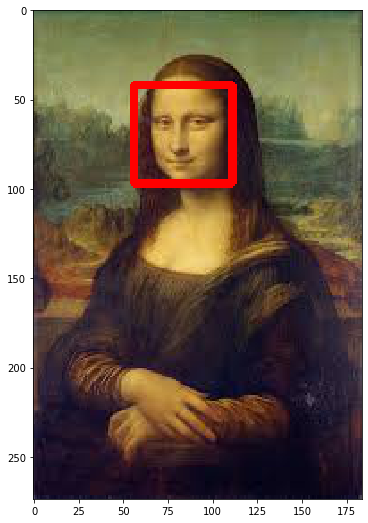

In [17]:
face_cascade = cv2.CascadeClassifier('../detector_architectures/haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(image, 1.1, 2)

image_with_detections = image.copy()

for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

# CNN Training

The CNN is defined in the file models. It's a simple CNN. The architecture is given by the next chunk.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=4048, bias=True)
  (bn1): BatchNorm1d(4048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=512, out_features=136, bias=True)
)


In [28]:
from torch.utils.data import Dataset, DataLoader
# we load the data as batches 

batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [29]:
# we do the same for the test data

test_dataset = ImageDataset(file='../data/test_frames_keypoints.csv',dir_='../data/test/',transform=transform)

batch_size = 64

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [33]:
k = 0
while k <= 1:
    for i, j in enumerate(test_loader):
        k +=1
        images = j['image']
        key_pts = j['keypoints']

        images = images.type(torch.FloatTensor)

        output_pts = net.forward(images)

        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        break 



In [53]:
def plot_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # call show_all_keypoints
        plot_keypoints(np.squeeze(image), predicted_key_pts)
            
        plt.axis('off')

    plt.show()
    

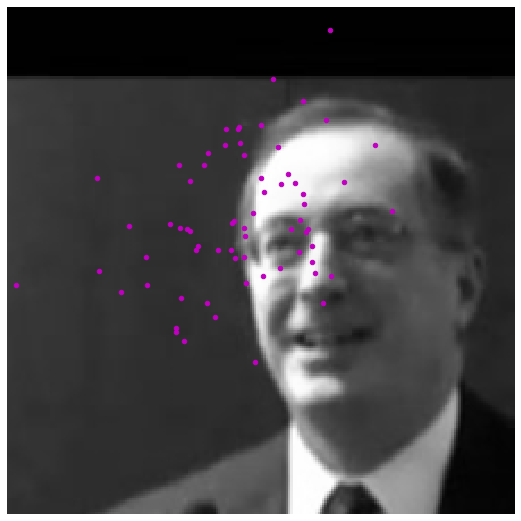

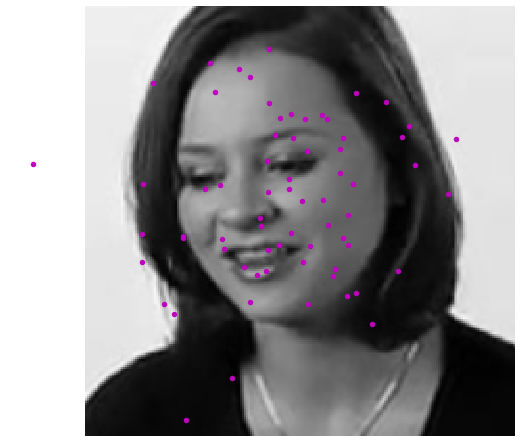

In [55]:
plot_output(images,output_pts,batch_size=2)

In [56]:
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters())


In [57]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            
        else:
            test_loss = 0

        
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                model.eval()
                for batch, data in test_loader:
                    MSE = net(batch)
                    test_loss += criterion(MSE, data)
            #scheduler.step(test_loss)
            model.train()        
            train_losses.append(running_loss/len(train_loader))
            test_loss = test_loss/len(test_loader)
            test_losses.append(test_loss/len(test_loader))

            
            
            if batch_i % 10 == 9:    # print every 10 batches
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Batch: {}".format(batch_i+1),
                      "Training Loss: {:.3f}.. ".format(np.sqrt(running_loss/len(train_loader))))
                running_loss = 0.0
    print('Finished Training')


In [58]:
train_net(1)

KeyboardInterrupt: 